In [10]:
import emcee
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks,argrelmin
from scipy.stats import median_absolute_deviation
import eleanor
import urllib
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import TessTargetPixelFile
import eleanor
from astropy.io import ascii,fits
from astropy.table import Table,join,Column
import astropy.units as u
import bokeh
import sys
from scipy.signal import savgol_filter
from requests.exceptions import HTTPError
import matplotlib.gridspec as gridspec
plt.rcParams['font.size']=12
import glob
from PyPDF2 import PdfFileMerger,PdfFileReader
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
import pandas as pd
from astroquery.gaia import Gaia
from uncertainties.umath import *
from uncertainties import ufloat
from uncertainties import unumpy
import statsmodels.distributions.empirical_distribution as emp
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord
from collections import Counter
plt.rcParams['font.size']= 18
import sigfig as sf
from IPython.display import display, Math


In [20]:
def get_acf_period(lc,smth=350):
    #t = data['time']
    #y = (data['flux'] - 1) * 1e3
    #yerr = (data['flux_err']) * 1e3

    t = lc.time
    y = (lc.flux-1) * 1e3
    #print(y)
    yerr = lc.flux_err * 1e3

    delta_t = np.median(np.diff(t))
    new_t = np.arange(t.min(), t.max(), delta_t)
    y_interp = np.interp(new_t, t, y)
    emp_acorr = emcee.autocorr.function_1d(y_interp) #* np.var(y_interp)

    #emp_acorr = emcee.autocorr.function_1d(y) * np.var(y)

    new_f = np.zeros(len(new_t))

    for i in range(len(lc.time)):
        t_diffs = np.abs(new_t - t[i])
        minindx = np.argmin(t_diffs)
        new_f[minindx] = y[i]

    #emp_acorr = emcee.autocorr.function_1d(y_interp)
    emp_acorr = emcee.autocorr.function_1d(new_f)

    #tau = np.arange(len(emp_acorr)) * delta_t

    #print(smth)

    emp_acorr_smooth = gaussian_filter1d(emp_acorr,smth*delta_t)
    #emp_acorr_smooth = gaussian_filter1d(emp_acorr,150*delta_t)

    #print(emp_acorr_smooth)
    peakinds = find_peaks(emp_acorr_smooth)[0]
    peakvals = emp_acorr_smooth[peakinds]
    #print(peakinds)
    valinds = argrelmin(emp_acorr_smooth)[0]
    #print(valinds)

    tau = np.arange(len(emp_acorr_smooth)) * delta_t

    #emp_acorr_smooth[peakinds[0]] - emp_acorr_smooth[peakinds[1]] > 0
    peakheights = np.zeros(len(peakinds)-1)
    for i in range(len(peakinds)-1):
        peakheights[i] = np.mean((emp_acorr_smooth[peakinds[i]]-emp_acorr_smooth[valinds[i]], emp_acorr_smooth[peakinds[i]]-emp_acorr_smooth[valinds[i+1]]))

    #print(peakheights)

    if len(peakheights) != 0:

        maxindx = np.argmax(peakheights)

        if maxindx == 1:
            maxindx = 1
            #print('!')

        elif maxindx != 1:
            maxindx = 0

        period=tau[peakinds[maxindx]]
        #print(period)
        maxheight=peakheights[maxindx]
        maxpeakval=peakvals[maxindx]


        integerinds = np.array([2,3,4,5],dtype=int)
        integermults = [period * n for n in range(2,6)]
        
        #integerinds = np.array([2,3,4,5,6,7,8,9,10],dtype=int)
        #integermults = [period * n for n in range(2,11)]
        
        #integerinds = np.array([2,3,4,5,6,7,8,9,10],dtype=int)
        #integermults = [period * n for n in range(2,11)]

        tau_prev = period
        periodmults = np.array([])
        linfit_peakinds = np.array([],dtype=int)
        peakdiffs = np.zeros(len(peakinds)-1)
        n = 1
        #for i in range(len(integermults)):
        #    for j in range(len(peakinds)):
        #        if (np.abs(integermults[i] - tau[peakinds[j]])/period <= 0.1) & ((tau[peakinds[j]]-tau_prev) > 0.5*period):
        #            #print(i,j)
        #            periodmults = np.concatenate((periodmults,[tau[peakinds[j]]]))
        #            tau_prev = tau[peakinds[j]]
        #            linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(j)]))
        #            n += 1

        for i in range(len(integermults)):
            for j in range(len(peakinds)-1):
                peakdiffs[j] = np.abs(integermults[i] - tau[peakinds[j]])/period
            if np.min(peakdiffs) <= 0.2: # change to 0.2?
                jj = np.argmin(peakdiffs)
                #if peakheights[jj]>= 0.5 * maxheight #0.1:
                if (peakheights[jj]>= 0.5 * maxheight) | (peakheights[jj] >= 0.1):
                #if (peakheights[jj]>= 0.1 * maxheight) | (peakheights[jj] >= 0.01):

                    periodmults = np.concatenate((periodmults,[tau[peakinds[jj]]]))
                #linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(jj)]))
                    linfit_peakinds = np.concatenate((linfit_peakinds,[integerinds[i]]))
                    n += 1
                #if (np.abs(integermults[i] - tau[peakinds[j]])/period <= 0.1) & ((tau[peakinds[j]]-tau_prev) > 0.5*period):
                    #print(i,j)
                    #periodmults = np.concatenate((periodmults,[tau[peakinds[j]]]))
                    #tau_prev = tau[peakinds[j]]
                    #linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(j)]))


        #print(n)
        tauslice = tau[valinds[maxindx]:valinds[maxindx+1]]
        acfslice = emp_acorr_smooth[valinds[maxindx]:valinds[maxindx+1]]
        #plt.plot(tauslice,acfslice)
        halfheight = maxheight/2
        halfheightval = maxpeakval - halfheight
        #if maxheight <0:
        #    halfmax = maxheight*2
        #if maxheight < 0:
        #    halfmax = maxheight*2
        #print(halfmax)
        #print(acfslice)
        #absdiffs = np.abs(maxheight/2 - acfslice)
        absdiffs = np.abs(halfheightval - acfslice)
        #print(absdiffs)
        #print(absdiffs)
        #print(maxheight)
        #print(acfslice)
        minval1 = np.argmin(absdiffs)
        absdiffs=np.delete(absdiffs,minval1)
        minval2 = np.argmin(absdiffs)
        #print(minval1,minval2)
        #print(tauslice)
        #print(tauslice[minval1])
        #
        #sigma_from_fwhm = (np.abs(period - tauslice[minval1]) + np.abs(period - tauslice[minval2]))/2.35482004503
        sigma_from_fwhm = (np.abs(period - tauslice[minval1]) + np.abs(period - tauslice[minval2]))/2

        if (minval1 == minval2) | (minval1 == minval2+1) | (minval1 == minval2-1):
                #print('!!!')
                sigma_from_fwhm = (np.abs(period - tauslice[minval1]) * 2)/2 #2.35482004503
                #print(period)
                ##print(tauslice[minval1])
                #print(sigma_from_fwhm)

        #print(sigma_from_fwhm)

        linfit_peakinds = np.concatenate(([maxindx],linfit_peakinds))
        #linfit_peakinds += 1
        linfit_peakinds = np.concatenate(([0],linfit_peakinds))
        #if linfit_peakinds[1] == 2:
        #    linfit_peakinds = linfit_peakinds / 2
        #print(linfit_peakinds)
        if linfit_peakinds[1] == 0:
            linfit_peakinds[1] = 1

        e_period_hwhm = sigma_from_fwhm
        #print(np.str(n))
        if (n == 1) | (np.sum(np.diff(np.diff(linfit_peakinds)))) != 0:
            periodmults = np.array([0,period])
            period_unc = e_period_hwhm #sigma_from_fwhm
            finalperiod = period
            e_period_mad = -1
            e_period_std = -1

        elif n > 1:
            #print('!')
            periodmults = np.concatenate(([0,period],periodmults))
            #print(periodmults)
            period_diffs = np.diff(periodmults)
            #print(period_diffs)
            #print(period_diffs)
            #finalperiod = np.median(period_diffs)
            finalperiod = np.polyfit(linfit_peakinds,periodmults,1)[0]
            #print(linfit_peakinds)
            #print(periodmults)


            #print(median_absolute_deviation(period_diffs))
            #print(np.std(period_diffs))
            #print(n)
            e_period_mad = 1.483* median_absolute_deviation(period_diffs) / np.sqrt(n-1)
            e_period_std = np.std(period_diffs)

            #print(median_absolute_deviation(period_diffs))
            #period_unc = 1.483* median_absolute_deviation(period_diffs) / np.sqrt(n-1)

            ###period_unc = e_period_mad
            period_unc = e_period_std

            if period_unc == 0:
                #print('Period unc too small')
                period_unc = e_period_hwhm #sigma_from_fwhm #np.std(period_diffs) / np.sqrt(n-1)
    else:
        #print('!')
        finalperiod = -1
        period_unc = -1
        e_period_hwhm = -1
        e_period_mad = -1
        e_period_std = -1
        peakindx = -1
        valinds = -1
        maxheight = -1
        periodmults = [0,0]


    return finalperiod, period_unc, e_period_hwhm, e_period_mad, e_period_std, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults

In [5]:
vetperiods = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_ptbl_cdips_vetted.dat')
goodindx = vetperiods['classification'] == 'C'
vetperiods = vetperiods[goodindx]


mems = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_allCGmems.dat')
highprob = mems['proba'] > 0.68

In [6]:
lcfiles = np.array(glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/cdips_lcgen/Figs/Light_Curves/*'))
lcdir = '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/cdips_lcgen/Figs/Light_Curves/'

In [10]:
j=np.where(names_vetperiods == '5290664929967787264')[0][0]
names_vetperiods = vetperiods['source_id'].astype('str')
file = glob.glob(lcdir+'*'+names_vetperiods[j]+'*')[0]
print(names_vetperiods[j])

NameError: name 'names_vetperiods' is not defined

In [349]:
lctbl = ascii.read(file)
lc = lk.LightCurve(time=lctbl['time'],flux=lctbl['flux'],flux_err=lctbl['flux_err'])
pdg = lc.to_periodogram()
pdg.period_at_max_power

<Quantity 1.46897981 d>

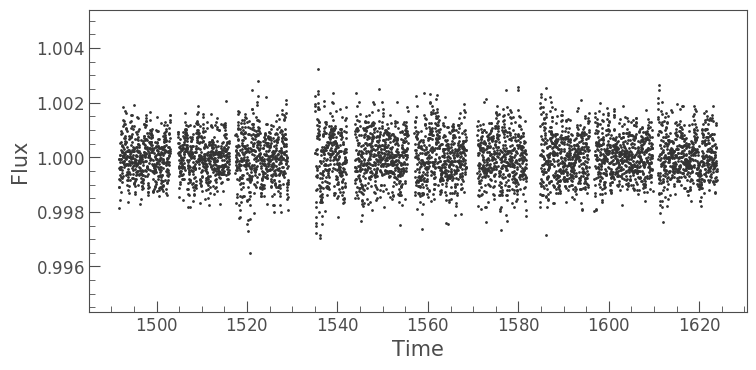

In [350]:
lc.scatter()

1.485445629572496 0.06874783304611898 1.4791637021116912 0.08333316631615162


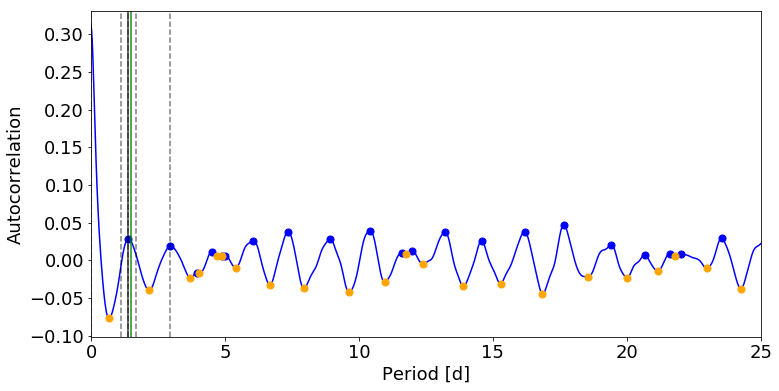

In [402]:
finalperiod, period_unc, e_period_hwhm, e_period_mad, e_period_std, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults = get_acf_period(lc,smth=250)

plt.figure(figsize=(12,6))
ax2=plt.subplot()
ax2.plot(tau, emp_acorr_smooth,color='blue',zorder=0)
ax2.scatter(tau[peakinds],emp_acorr_smooth[peakinds],color='blue',s=50)
ax2.scatter(tau[valinds],emp_acorr_smooth[valinds],color='orange',s=50)
ax2.axvline(finalperiod, color="green", alpha=0.9)
#for xx in range(1,6):
for xx in range(1,2):
    ax2.axvline(periodmults[1]*xx,color='k',alpha=.75)#,ls='dashed')
for yy in range(len(periodmults)):
    ax2.axvline(periodmults[yy],color='k',alpha=.5,ls='dashed')
ax2.axvline(periodmults[1]*.8, color="k", alpha=0.5,ls="dashed")
ax2.axvline(periodmults[1]*1.2, color="k", alpha=0.5,ls="dashed")

ax2.set_xlim(0,25)
ax2.set_xlabel('Period [d]')
ax2.set_ylabel('Autocorrelation')


print(vetperiods[j]['period'], vetperiods[j]['period_unc'], finalperiod, period_unc)

In [374]:
maxheight

0.07734501557231202

(0.95, 1.05)

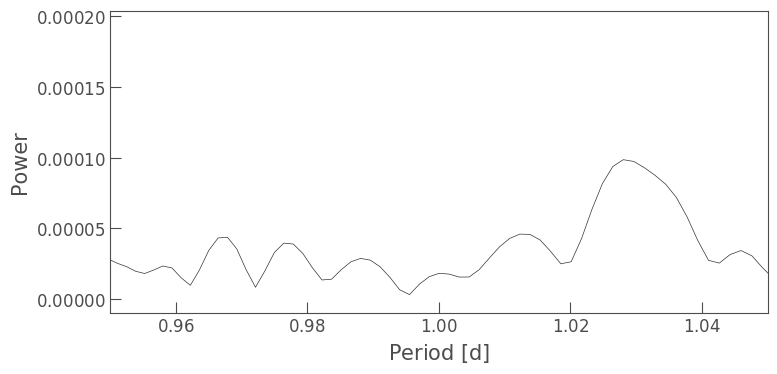

In [359]:
pdg.plot(view='period')
plt.xlim(0.95,1.05)

In [300]:
new_vetperiods = vetperiods.copy()

In [301]:
newperiods = np.zeros(len(vetperiods))
newperiod_uncs = np.copy(newperiods)

parr = np.arange(0,8,0.001)
agreement = parr
higher = parr + 0.34
lower = parr - 0.34

discrepant = np.zeros(len(vetperiods),dtype=bool)

for i in range(len(vetperiods)):
    file = glob.glob(lcdir+'*'+names_vetperiods[i]+'*')[0]
    lctbl = ascii.read(file)
    lc = lk.LightCurve(time=lctbl['time'],flux=lctbl['flux'],flux_err=lctbl['flux_err'])
    pdg = lc.to_periodogram()
    maxpow_per = pdg.period_at_max_power.value
    smth = 350
    if vetperiods[i]['period'] < 1:
        smth = 50
    finalperiod, period_unc, e_period_hwhm, e_period_mad, e_period_std, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults = get_acf_period(lc,smth=smth)
    newperiods[i] = finalperiod
    newperiod_uncs[i] = period_unc
    
    discrepant[i] = (newperiods[i] > np.interp(vetperiods[i]['period'],parr,higher)) | (newperiods[i] < np.interp(vetperiods[i]['period'],parr,lower))
    if discrepant[i]:
        if np.abs(maxpow_per - vetperiods[i]['period'])/vetperiods[i]['period'] <= 0.2:
            newperiods[i] = maxpow_per
            newperiod_uncs[i] = vetperiods[i]['period_unc']
        else:
            lc = lc.flatten()
            finalperiod, period_unc, e_period_hwhm, e_period_mad, e_period_std, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults = get_acf_period(lc,smth=smth)
            newperiods[i] = finalperiod
            newperiod_uncs[i] = period_unc
            
    if vetperiods[i]['e_period_std']==0:
        print(i)
        newperiod_uncs[i] = 0.01 * newperiods[i]
        
    new_vetperiods[i]['period'] = newperiods[i]
    new_vetperiods[i]['period_unc'] = newperiod_uncs[i]
    

/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2


/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


40
41


/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


57
65
76
96
132
134
149


/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


152


/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


178
182
199


[]

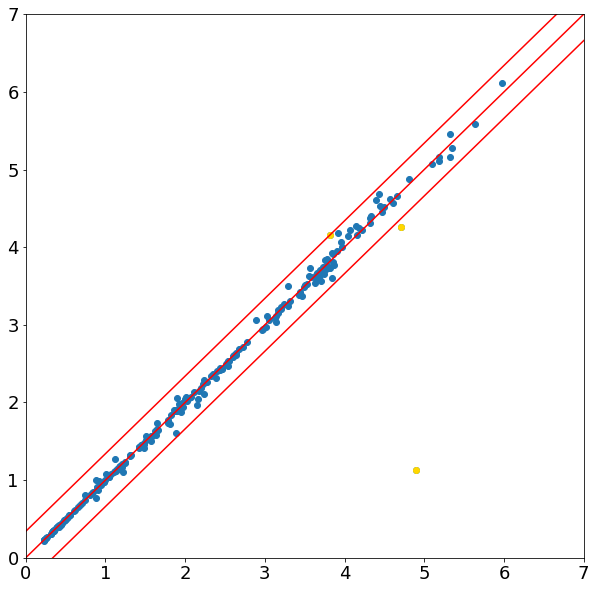

In [302]:

still_discrepant = (new_vetperiods['period'] > np.interp(vetperiods['period'],parr,higher)) | (new_vetperiods['period'] < np.interp(vetperiods['period'],parr,lower))
#still_discrepant = (newperiods > np.interp(vetperiods['period'],parr,higher)) | (newperiods < np.interp(vetperiods['period'],parr,lower))


plt.figure(figsize=(10,10))
plt.scatter(vetperiods['period'],new_vetperiods['period'])
plt.scatter(vetperiods['period'][still_discrepant],new_vetperiods['period'][still_discrepant],color='gold')

#plt.scatter(vetperiods['period'],newperiods)
#plt.scatter(vetperiods['period'][still_discrepant],newperiods[still_discrepant],color='gold')

#plt.errorbar(vetperiods['period'],newperiods,xerr=vetperiods['period_unc'],yerr=newperiod_uncs,linestyle='none')
plt.xlim(0,7)
plt.ylim(0,7)

plt.plot(parr,agreement,color='red')
plt.plot(parr,higher,color='red')
plt.plot(parr,lower,color='red')

plt.plot()

(-0.05, 2)

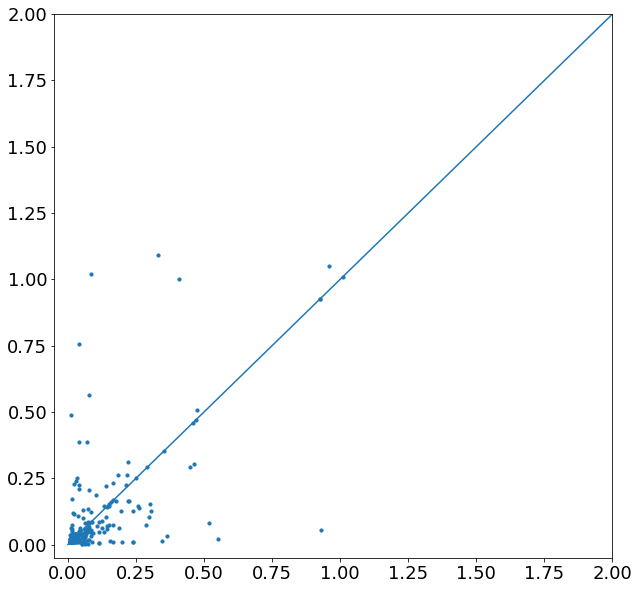

In [303]:
plt.figure(figsize=(10,10))
plt.scatter(vetperiods['period_unc'],new_vetperiods['period_unc'],s=10)
plt.plot([0,3],[0,3])
plt.xlim(-.05,2)
plt.ylim(-.05,2)

In [304]:
new_vetperiods[~still_discrepant].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/fulllc_periods.dat',format='ascii')

In [11]:
ssmems = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_papertbls_singlestars.dat')
ssmems = ssmems[ssmems['proba'] > 0.68]

In [308]:
fulllc_periods = new_vetperiods[~still_discrepant]

In [309]:
sini_periods = ascii.read('/Users/bhealy/Downloads/verifythese.txt')

In [310]:
bad = sini_periods['good'] == 0

In [311]:
for i in range(len(sini_periods[bad])):
    remindx = np.where(fulllc_periods['source_id'] == sini_periods['source_id'][bad][i])[0][0]
    fulllc_periods.remove_row(remindx)

In [312]:
fulllc_periods.rename_column('period_unc','e_period')
fulllc_periods.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/fulllc_periods.dat',format='ascii')

In [447]:
confirmed_periods = ascii.read('/Users/bhealy/Downloads/final68data.txt')

In [452]:
finalmask = np.isin(finalperiods_68['source_id'],confirmed_periods['source_id'])


In [453]:
finalperiods_68[finalmask]

source_id,period,e_period,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,ra,dec,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig
int64,float64,float64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,float64,float64,float64,float64
5289890495822656640,1.989866134025422,0.021245756424717755,0.43750813929364085,0.0,0.013176402047905867,1,C,119.49936785349912,-61.45191965058128,274.45652443155785,-16.18563905846991,2.3928190531459097,0.01890695217759307,-4.393270268704721,0.039592181423995655,11.401475527243258,0.037162114672072595,0.012834066,0.034496877,-0.3020553,0.030143429,0.23014058,0.058823388,-0.2513722,0.08350046,-0.1359186,-0.007402256,455,12.709742,0.9228382,0.699999988079071,NGC_2516,3.1241972000000002,297.19097999999997,0.0,0.0
5289898020605414016,2.2345069945390725,0.022345069945390726,0.5520938388071954,0.0,0.0,1,C,119.98416898329307,-61.32024360559023,274.4470383089242,-15.91888146770759,2.362036220041,0.022592674318478393,-4.712546041542891,0.04576224817146788,11.733439840450455,0.04675409759308582,0.094471,0.051852487,-0.053004943,0.08687148,0.30354747,0.10655951,-0.2859684,0.06595268,-0.11679387,0.16156341,413,12.634859,0.8862591,0.8999999761581421,NGC_2516,7.240514,376.11475,0.0,0.0
5289930181318610432,2.046413995219128,0.04082453826112902,0.5104268584400415,0.06611682078975804,0.05311584717240069,1,C,121.13929660975464,-61.34479131354677,274.7422043965664,-15.442528365609865,2.3884908308201847,0.03956593795486762,-5.996325742897152,0.07986416562888808,11.285662861416583,0.06402113272147258,-0.09037766,-0.3883745,-0.67335325,0.09366239,0.36055145,0.20421809,-0.3568515,0.5064942,-0.19008742,-0.045431316,264,10.764917,0.4116087,0.800000011920929,NGC_2516,8.342107,304.49652000000003,0.0,1.2560739669470197e-15
5289934751163440000,1.5833218432962897,0.22916500363498926,0.20832924637943506,0.022902631951581452,0.021245497850816367,1,C,121.15734269335677,-61.250432702202865,274.6607323173441,-15.389518896548115,2.4388671345052253,0.026805866704714697,-5.4977469463723265,0.05465186967286327,11.431481500600079,0.04818195625532095,0.12255578,0.07034077,-0.07658734,-0.081400275,0.2666709,0.0258292,-0.31808743,0.35445124,-0.11345839,0.05156331,204,11.357195,0.59317017,0.800000011920929,NGC_2516,9.478527,401.3126,0.0,0.0
5289958425026796288,0.33868801078892175,0.00833327267318964,0.06250125635415316,0.0,0.008333500847220421,1,C,121.28565505123679,-61.18736195636068,274.6343536109714,-15.304977045816903,2.4091882002309433,0.05364721138081558,-5.010441469558942,0.11122766528660019,11.31696637052315,0.10035107447776305,0.05425949,-0.031743843,-0.28042758,-0.047183275,0.22311863,0.0013237105,-0.23248485,0.20772423,-0.12612036,0.10145538,440,16.926434,2.1946259,0.699999988079071,NGC_2516,0.79059106,238.37921,0.0,0.0
5289982713061723008,3.833304915577174,0.12499907333403826,0.8125160783529282,0.3435530170975104,0.30602212278932905,1,C,120.9091449058326,-61.202491894163856,274.5576027083697,-15.471302280161437,2.3652509368700576,0.013387327265594655,-4.847132336108866,0.026984672523511888,10.826460697791378,0.0301961559776361,-0.11107961,-0.038307887,-0.29679903,0.13264479,0.1584229,0.16519792,-0.50542235,0.25189266,0.011207202,-0.061761662,389,13.048918,0.9114685,0.699999988079071,NGC_2516,0.88803303,211.31667000000002,0.0,0.0
5289987115408111360,1.4696316665570648,0.010206129546499049,0.3645905153825879,0.0,0.016666994988918302,1,C,120.78885177123001,-61.110000051400604,274.44452235785235,-15.478055091388377,2.4300253494240045,0.

In [496]:
bprp_errors=pd.read_csv('/Users/bhealy/Downloads/bprp_g_errors_cdips.csv')
bprp_errors = bprp_errors[['source_id','phot_bp_mean_flux_over_error','phot_rp_mean_flux_over_error','phot_g_mean_flux_over_error']]
JAP_pd = finalperiods_68[finalmask].to_pandas()
JAP_merge=pd.merge(JAP_pd,bprp_errors,on='source_id')
finalperiods_merge = Table(data=JAP_merge.values,names=JAP_merge.columns,dtype=JAP_merge.dtypes)

In [497]:
deltaF = np.sqrt((1/finalperiods_merge['phot_bp_mean_flux_over_error'])**2 + (1/finalperiods_merge['phot_rp_mean_flux_over_error'])**2)
deltaM = np.log10(1+deltaF)/0.4

deltaG = np.log10(1+1/finalperiods_merge['phot_g_mean_flux_over_error'])/0.4

In [498]:
finalperiods_merge.add_column(Column(deltaM,'e_bp_rp'))
finalperiods_merge.add_column(Column(deltaG,'e_gmag'))

In [478]:
#finalperiods_68 = join(fulllc_periods,ssmems)
#finalperiods_68
#finalperiods_68[finalmask].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/final_verified_periods_68conf.dat',format='ascii')

<Container object of 3 artists>

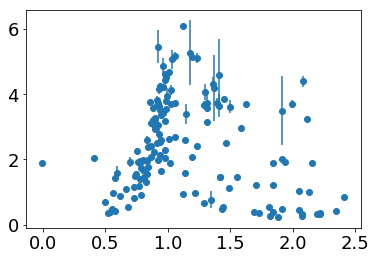

In [474]:
plt.scatter(finalperiods_merge['bp_rp'],finalperiods_merge['period'])
#plt.scatter(finalperiods_68[weirdbox]['bp_rp'],finalperiods_68[weirdbox]['period'])
plt.errorbar(finalperiods_merge['bp_rp'],finalperiods_merge['period'],xerr=finalperiods_merge['e_bp_rp'],yerr=finalperiods_merge['e_period'],linestyle='none')

In [500]:
#finalperiods_68 = join(fulllc_periods,ssmems)
#finalperiods_68
finalperiods_merge.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/final_verified_periods_68conf.dat',format='ascii')

In [4]:
finalperiods = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/final_verified_periods_68conf.dat')

In [415]:
weirdbox = (finalperiods_68['bp_rp'] > 1.2) & (finalperiods_68['bp_rp'] < 1.55) & (finalperiods_68['period'] > 3) & (finalperiods_68['period'] < 5)

np.sum(weirdbox)


13

In [445]:
finalperiods_68[weirdbox]['source_id','period','e_period'].write('/Users/bhealy/Downloads/weirdbox_stars.dat',format='ascii')

In [15]:
finalperiods[finalperiods['source_id']==5290728834785867264]

source_id,period,e_period,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,ra,dec,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_g_mean_flux_over_error,e_bp_rp,e_gmag
int64,float64,float64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64
5290728834785867264,2.933921248505689,0.05527694187073326,0.7187629058025777,0.02290349249541918,0.04370115335317291,1,C,118.7091202133573,-60.84460613454599,273.7125331950683,-16.247881170417223,2.3752586835062957,0.021751043745101725,-4.5468617627169845,0.061103409746668884,11.258667913859838,0.04808462979909604,-0.066299595,-0.19201551,-0.46036315,0.07202131,0.10132147,0.11754187,-0.5981909,0.0864627,0.11737899,0.014937217,343,12.838233,0.90008163,0.800000011920929,NGC_2516,5.2477064,303.2124,0.0,0.0,635.6642,604.4357,1469.703,0.002475885306048559,0.0007384941036150768


In [21]:
file = glob.glob(lcdir+'*'+np.str(5290728834785867264)+'*')[0]
lctbl = ascii.read(file)
lc = lk.LightCurve(time=lctbl['time'],flux=lctbl['flux'],flux_err=lctbl['flux_err'])
#lc=lc.remove_outliers()
pdg = lc.to_periodogram()
maxpow_per = pdg.period_at_max_power.value
smth = 350

finalperiod, period_unc, e_period_hwhm, e_period_mad, e_period_std, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults = get_acf_period(lc,smth=smth)


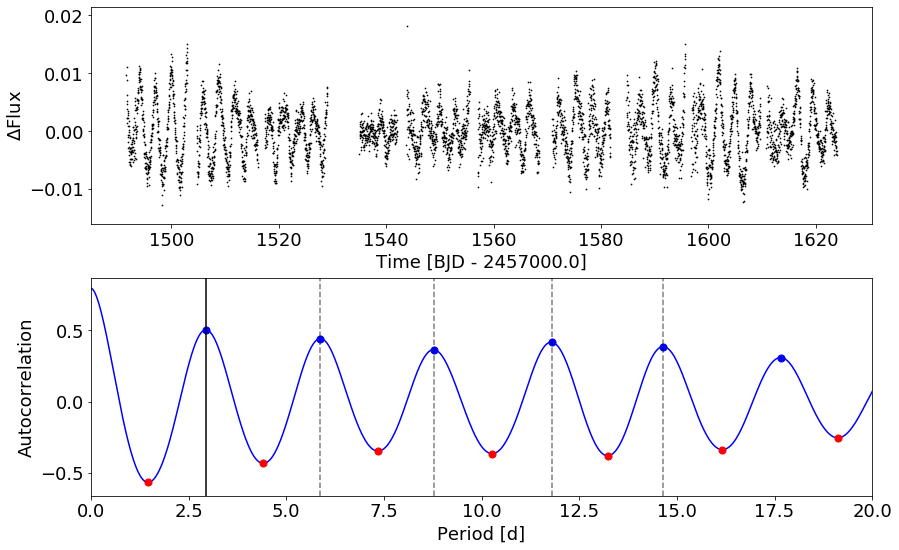

In [36]:
#plt.figure(figsize=(12,12))
#fig,ax = plt.subplots(2,1,figsize=(10,16))
fig,ax = plt.subplots(2,1,figsize=(14,9))

plt.subplots_adjust(hspace=0.25)
ax1 = ax[0]
ax2 = ax[1]
#ax3 = ax[2]

lcM2 = lc.copy()
lcM2.flux = (lcM2.flux - 1)
lcM2.scatter(ax=ax1,color='black',normalize=False,s=.5)
ax1.set_xlabel('Time [BJD - 2457000.0]')
ax1.set_ylabel('$\Delta$Flux')
#ax1.set_ylim(.975,1.025)
#ax1.text(1491,.02,'Gaia DR2 ' + np.str(5290728834785867264))
#ax1.text(1510,.02,'$T$ mag. = ' + np.str(12.37))


#ax2=plt.subplot()
ax2.plot(tau, emp_acorr_smooth,color='blue',zorder=0)
ax2.scatter(tau[peakinds],emp_acorr_smooth[peakinds],color='blue',s=50)
ax2.scatter(tau[valinds],emp_acorr_smooth[valinds],color='red',s=50)
#ax2.axvline(finalperiod, color="green", alpha=0.9)
ax2.axvline(finalperiod, color="black", alpha=1)

#for xx in range(1,6):
#for xx in range(1,2):
#    ax2.axvline(periodmults[1]*xx,color='k',alpha=.75)#,ls='dashed')
for yy in range(2,len(periodmults)):
    ax2.axvline(periodmults[yy],color='k',alpha=.5,ls='dashed')
#ax2.axvline(periodmults[1]*.8, color="k", alpha=0.75,ls="dotted")
#ax2.axvline(periodmults[1]*1.2, color="k", alpha=0.75,ls="dotted")
ax2.set_xlim(0,20)
ax2.set_xlabel('Period [d]')
ax2.set_ylabel('Autocorrelation')

#lcM.to_periodogram().plot(view='period',ax=ax3,color='black',linewidth=1)
#ax3.axvline(vetperiods[lcindxfinal]['period'], color="k", alpha=0.5,ls="dashed")
#ax3.set_xlim(0,20)
#ax2.text(11,.8,'Period = '+np.str(np.round(vetperiods[lcindxfinal]['period'],3))+' $\pm$ '+np.str(np.round(vetperiods[lcindxfinal]['period_unc'],3))+' d',backgroundcolor='white')
#11, .0058
fig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/lc_acf_notext_full.pdf',bbox_inches='tight')


In [39]:
1500+2457000

2458500

In [58]:
lcM2.to_table().write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig2/fig2_lightcurve.txt',format='ascii')




In [60]:
acftbl=Table(data=[tau,emp_acorr_smooth],names=['period','acf'])

In [61]:
acftbl.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig2/fig2_acf.txt',format='ascii')

(18, 5)

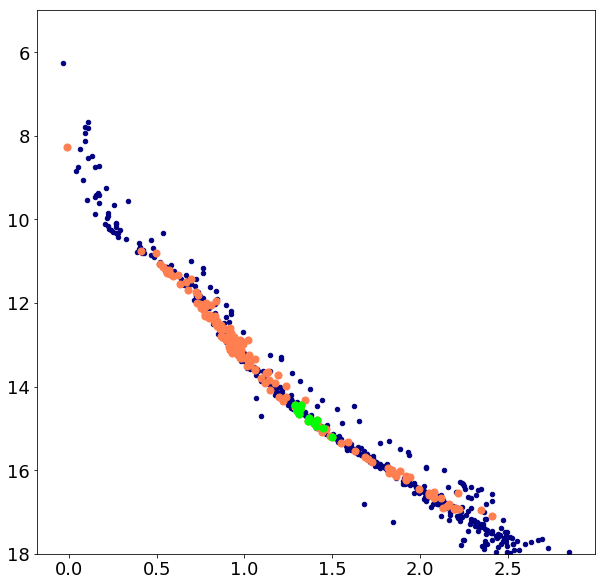

In [441]:
plt.figure(figsize=(10,10))
plt.scatter(mems[highprob]['bp_rp'],mems[highprob]['phot_g_mean_mag'],color='navy',s=20)
plt.scatter(finalperiods_68['bp_rp'],finalperiods_68['phot_g_mean_mag'],color='coral',s=50)
plt.scatter(finalperiods_68[weirdbox]['bp_rp'],finalperiods_68[weirdbox]['phot_g_mean_mag'],color='lime',s=50)

plt.ylim(18,5)

(17.5, 8)

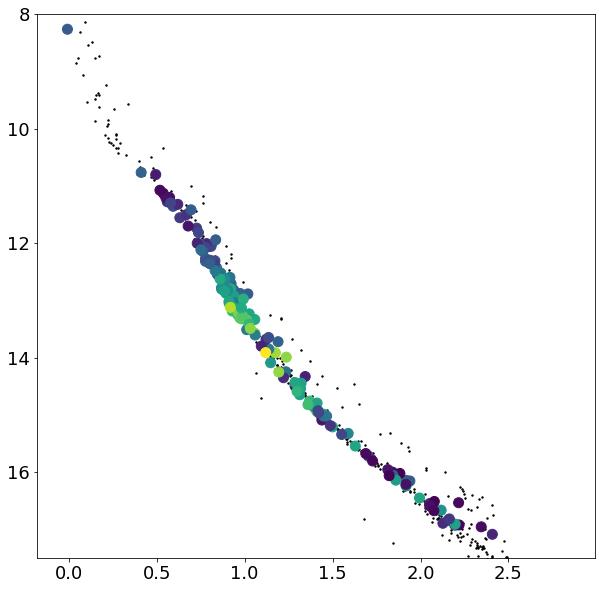

In [440]:
plt.figure(figsize=(10,10))
plt.scatter(mems[highprob]['bp_rp'],mems[highprob]['phot_g_mean_mag'],color='black',s=2,alpha=1)
plt.scatter(finalperiods_68['bp_rp'],finalperiods_68['phot_g_mean_mag'],s=100,c=finalperiods_68['period'])
plt.ylim(17.5,8)
#plt.xlim(0.5,1.5)

In [55]:
np.max(finalperiods['period'])

6.108318223804234

In [57]:
np.mean(finalperiods['e_period']/finalperiods['period'])

0.033318944895668154

(array([25., 18., 28., 17., 14., 28., 13.,  8.,  6.,  1.]),
 array([0.22142809, 0.8101171 , 1.39880611, 1.98749513, 2.57618414,
        3.16487315, 3.75356217, 4.34225118, 4.9309402 , 5.51962921,
        6.10831822]),
 <a list of 10 Patch objects>)

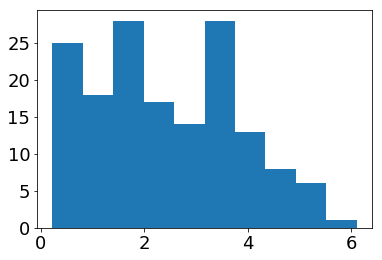

In [323]:
plt.hist(finalperiods_68['period'])

(18, 5.5)

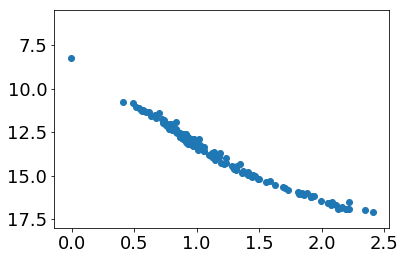

In [324]:
plt.scatter(finalperiods_68['bp_rp'],finalperiods_68['phot_g_mean_mag'])
plt.ylim(18,5.5)

In [327]:
finalperiods_68[finalperiods_68['source_id']==5290664929967787264]

source_id,period,e_period,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,ra,dec,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig
int64,float64,float64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,float64,float64,float64,float64
5290664929967787264,1.4166638273745775,0.38541589421220124,0.37500690948218107,0.0264466875287171,0.05387641159076604,1,C,119.25998129356094,-61.03465617585395,274.0156045458683,-16.096273101399444,2.423858840447574,0.02465442465699191,-4.249929974106201,0.04965415719118762,11.316085418448882,0.043708430181997646,-0.1828444,-0.11409408,-0.44087377,0.19312134,0.33971387,0.27938685,-0.2737395,0.29234594,-0.10523812,-0.1598389,319,11.817455,0.7374668,1.0,NGC_2516,3.2343655,238.40315,0.0,0.0


In [ ]:
#1.4791637021116912 0.08333316631615162

In [407]:
np.where(finalperiods_68['source_id'] == 5290664929967787264)#['e_period'] = 0.01

(array([40]),)

In [410]:
#finalperiods_68[40]['period']=1.4791637021116912

In [256]:
finalperiods[110]

source_id,period,e_period,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,ra,dec,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster
int64,float64,float64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8
5290739937276199168,0.9791653607971965,0.01,0.23958301381208003,0.0,0.01,1,C,119.3006304143167,-60.55244766708006,273.57969309826,-15.856907716932549,2.3240196088962195,0.020478406837300747,-4.894071191135896,0.039022696600599927,10.64883259578083,0.044790693397845416,0.026691169,-0.081695,-0.19686648,-0.09615798,0.34532517,-0.068477355,-0.073668525,0.10146824,0.07876566,-0.09459209,379,14.352622,1.2207375,0.699999988079071,NGC_2516


In [259]:
np.sum(finalperiods['e_period_std']==0)

11

In [138]:
for i in range(len(vetperiods)):
    if discrepant[i]:
        file = glob.glob(lcdir+'*'+names_vetperiods[i]+'*')[0]
        lctbl = ascii.read(file)
        lc = lk.LightCurve(time=lctbl['time'],flux=lctbl['flux'],flux_err=lctbl['flux_err'])
        lc = lc.flatten()
        pdg = lc.to_periodogram()
        smth = 350
        if vetperiods[i]['period'] < 1:
            smth = 50
        finalperiod, period_unc, e_period_hwhm, e_period_mad, e_period_std, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults = get_acf_period(lc,smth=smth)
        newperiods[i] = finalperiod
        newperiod_uncs[i] = period_unc

/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc

[]

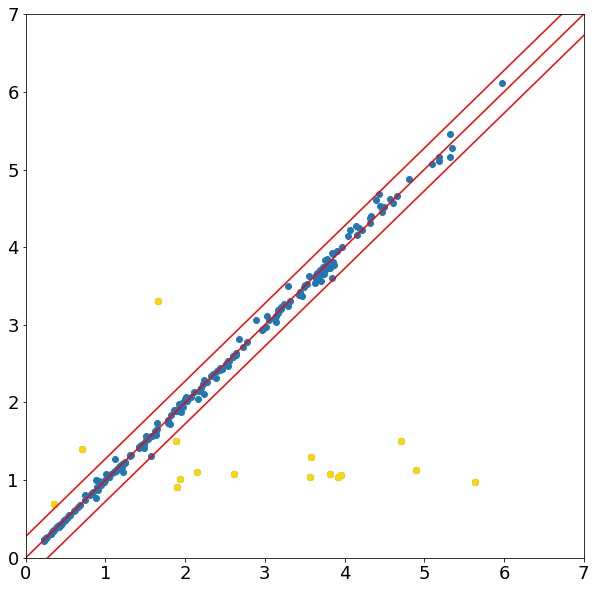

In [142]:
plt.figure(figsize=(10,10))
plt.scatter(vetperiods['period'],newperiods)
plt.scatter(vetperiods['period'][discrepant],newperiods[discrepant],color='gold')

#plt.errorbar(vetperiods['period'],newperiods,xerr=vetperiods['period_unc'],yerr=newperiod_uncs,linestyle='none')
plt.xlim(0,7)
plt.ylim(0,7)

plt.plot(parr,agreement,color='red')
plt.plot(parr,higher,color='red')
plt.plot(parr,lower,color='red')

plt.plot()

In [141]:
discrepant = (newperiods > np.interp(vetperiods['period'],parr,higher)) | (newperiods < np.interp(vetperiods['period'],parr,lower))
vetperiods[discrepant].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/discrepant_periods.dat',format='ascii',overwrite=True)